# Digits Classification with more complicated version of MNIST dataset.  
28x28 greyscale images are flattened into a 784-elements array. The train_data.csv contains also the target (digits ranging from 0 to 9) as the last column.  

----

The workflow will be as follows:  
  
1. First, load the dataset and check its shape.  
2. Split the data between training and validation sets.  
3. Start formating the data.  
4. Display few images to visualize the digits.  
5. Train several models with different architectures, additional options and optimized hyperparameters. For each of the model we will proceed as follows:  
    * Build and visualize the architecture 
    * Compile and train the model 
    * Visualize the quantities (loss and accuracy) displayed during training 
    * Analyse and discuss improvements (or not) over previous models 
6. Produce predictions for digits of the test set and check how closed the predictions match the labels.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from platform import python_version

print('python version: ' + str(python_version()))
print('tf version: ' + str(tf.__version__))
print('keras version: ' + str(keras.__version__))

python version: 3.7.9
tf version: 2.3.1
keras version: 2.4.0


# PREPARING training and validation sets

We split the data set between 2 sets: train (80%) and validation (20%)

In [3]:
from sklearn.model_selection import train_test_split

# Import data from file 'train_data.csv' and 'test_data.csv'
train_data=pd.read_csv("train_data.csv", header = None)
test_data= pd.read_csv("test_data.csv", header = None)

# Isolate target (= digit) from training data
train_data2=train_data.iloc[:,:-1]
train_labels=train_data.iloc[:,-1:]

train_set, validation_set=train_test_split(train_data2, test_size=0.2,
                                           random_state=42, shuffle=False)
train_labels, validation_labels=train_test_split(train_labels, test_size=0.2, 
                                                 random_state=42, shuffle=False)

In [4]:
# Print dataset shapes and data type
print('Dataset Shape:')
print('train_set: ' + str(train_set.shape))
print('validation_set:  '  + str(validation_set.shape))
print('train_labels: ' + str(train_labels.shape))
print('validation_labels: ' + str(validation_labels.shape))
print('\nData Type: ' + str(type(train_set[0].iloc[0])))

Dataset Shape:
train_set: (9600, 784)
validation_set:  (2400, 784)
train_labels: (9600, 1)
validation_labels: (2400, 1)

Data Type: <class 'numpy.float64'>


# PREPARING the labels

We also need to categorically encode the labels because we are dealing with a classification problem and therefore we will be using the "categorical_crossentropy" as a loss function.

In [5]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
validation_labels = to_categorical(validation_labels)

In [6]:
# Print new dataset shapes
print('Dataset Shape:')
print('train_set: ' + str(train_set.shape))
print('validation_set:  '  + str(validation_set.shape))
print('train_labels: ' + str(train_labels.shape))
print('validation_labels: ' + str(validation_labels.shape))

Dataset Shape:
train_set: (9600, 784)
validation_set:  (2400, 784)
train_labels: (9600, 10)
validation_labels: (2400, 10)


# Displaying some digits

In [7]:
# "Unflatten" the data
train_images_flatten = np.array(train_set).reshape(len(train_set), 28, 28)
validation_images_flatten = np.array(validation_set).reshape(len(validation_set), 28, 28)

# Print new Tensors abtained
print('train_images_flatten: ' + str(train_images_flatten.shape))
print('validation_images_flatten:  '  + str(validation_images_flatten.shape))

train_images_flatten: (9600, 28, 28)
validation_images_flatten:  (2400, 28, 28)


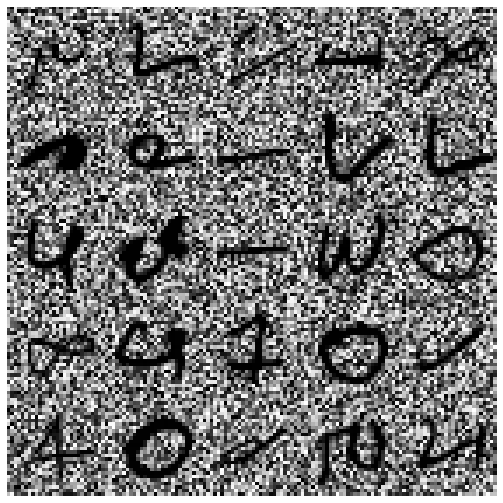

In [8]:
# Function to plot a set of digits
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
# Plot some more digits
plt.figure(figsize=(9,9))
example_images = train_images_flatten[:25]
plot_digits(example_images, images_per_row=5)
plt.show()

# MODEL n°1  

## Basic Architecture with 2 `Dense layers`

The network consists of a sequence of two Dense layers, which are fully connected neural layers. The second (and last) layer is a 10-class softmax layer, which means it will return an array of 10  probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of the 10 digit classes.  

In [9]:
from keras import models
from keras import layers

NUM_CLASSES = 10
input_shape = (28*28,)  

model_dense = models.Sequential()
model_dense.add(layers.Dense(64, activation='relu', input_shape=input_shape))
model_dense.add(layers.Dense(NUM_CLASSES, activation='softmax'))

## View of the model architecture

In [10]:
model_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


## COMPILATION step

To make the network ready for training, we need to proceed with the compilation step which consists of:  
* The `optimizer` through which the network will update itself based on the data it sees and its loss function. To start with we will use the rmsprop.  
* The `loss function` used by the network to measure its performance on the training data. Here it has to be categorical crossentropy because we are dealing with a 10-class classification problem.  
* The `metrics` to monitor during training and validating. Here we look at accuracy that is the rate of correctly classified images.

In [11]:
from keras import optimizers

model_dense.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])              

## TRAINING of the model

We are now ready to train the network by fitting the model to its training data.  
* The network will start to iterate on the training data (each iteration over all the training data is an `epoch`). At each iteration, the network will compute the gradients of the weights with regard to the loss and update the weights accordingly.  
* Here we will use a few callbacks options especially in on order to stop training when the validation loss in no longer improving (`EarlyStopping`) and to dynamically adjust the value of the learning rate during training (`ReduceLROnPlateau`).

In [12]:
from keras import callbacks

callbacks_list = [callbacks.EarlyStopping(monitor='loss', patience=5,),
                  callbacks.ModelCheckpoint(filepath='model_dense.h5', monitor='val_loss', save_best_only=True,),
                  callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,)]

history_dense = model_dense.fit(train_set, train_labels, 
                                epochs=100,
                                callbacks = callbacks_list,
                                validation_data = (validation_set, validation_labels),
                                verbose=0,)

## Visualizing the loss and accuracy displayed during training
* The loss of the network over the training and the validation data.  
* The accuracy of the network over the training and the validation data.

In [13]:
# Since we are going to use this plotting each time we apply a new model let's define a function
def plot_history(history):
    fig, ax = plt.subplots(1,1, figsize=(11,7)) # create axes object

    SIZE = 16
    # Plot
    ax.plot(history.loss, ls='-.', lw=4, label=r'Training loss')
    ax.plot(history.accuracy, lw=4, label=r'Training accuracy')
    ax.plot(history.val_loss, ls='-.', lw=4, label=r'Validation loss')
    ax.plot(history.val_accuracy, lw=4, label=r'Validation accuracy')

    # Create labels
    ax.set_xlabel('$x$', fontsize=SIZE)
    ax.set_ylabel('$y$', fontsize=SIZE)

    ax.tick_params(labelsize=SIZE)

    ax.legend(fontsize=SIZE)

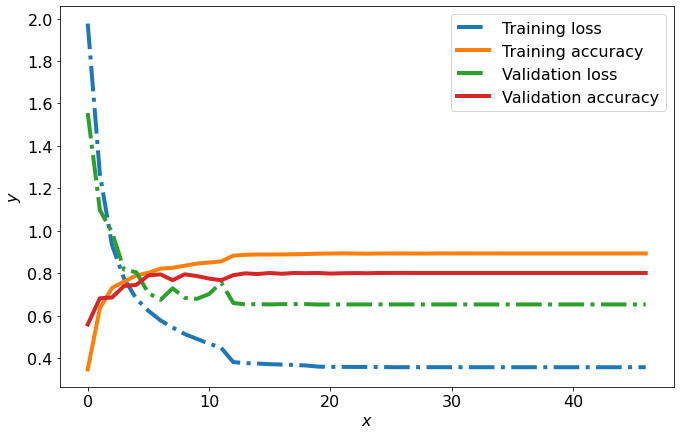

In [14]:
history = pd.DataFrame(history_dense.history)
plot_history(history)

***
<font color='blue'>In this graph we see clearly the effect of overfitting: the training loss keeps improving as the number of iterations grows while the validation loss reaches an optimal value and then start degrading.
</font>
***

In [15]:
validation_loss_model_dense, validation_acc_model_dense = model_dense.evaluate(validation_set,
                                                                               validation_labels)
print('\nvalidation_acc with model_dense:', round(validation_acc_model_dense, 3))

75/75 [==============================] - 0s 2ms/step - loss: 0.6530 - accuracy: 0.8012

validation_acc with model_dense: 0.801


***
<font color='blue'> <b>Conclusion with Model 1</b> : With this simple first model composed of 2 dense layers and using the rmsprop optimiser, the validation accuracy reaches a <b>score of 80%</b>. We will now try to improve this score with a more sophisticated model.</font>
***

### Using the model to make PREDICTIONS

In [16]:
print('First 10 labels of the validation set: \n')
for i in range(10):
    print(validation_labels[i])
    
print('\nFirst 10 predictions made by the model: \n')
validation_new = validation_set[:10]
label_predict = model_dense.predict(validation_new)
for i in range(10):
    print(label_predict[i].round(2))

First 10 labels of the validation set: 

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

First 10 predictions made by the model: 

[0.   0.   0.   0.   0.15 0.04 0.   0.59 0.   0.22]
[0.   0.02 0.01 0.   0.   0.   0.   0.   0.95 0.01]
[0.   0.   0.03 0.   0.61 0.   0.21 0.07 0.   0.08]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0.   0.   0.   0.06 0.   0.9  0.   0.   0.03 0.01]
[0.   0.   0.04 0.   0.   0.   0.96 0.   0.   0.  ]
[0.   0.   0.   0.99 0.   0.01 0.   0.   0.   0.  ]
[0.   0.   0.03 0.05 0.   0.04 0.78 0.   0.1  0.  ]
[0.   0.   0.97 0.01 0.   0.   0.   0.   0.02 0.  ]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


***
<font color='blue'> Here above we visualize the probability that the current digit image belongs to one of the 10 digit classes. The first 10 digits of validation set have all been correctly classified (probability>0.5) however not all with the same certainty.</font>
***

# MODEL n°2  

## Simple convolution network with a stack of `Conv2D` and `MaxPooling2D` layers

Let's build this new architecture:
* Mainly the `convolutional layers` embodies the idea that a representation meaningful at a certain location of the image should be used everywhere. This is done through the application of relevant filters.  
* `Pooling layers` reduce the dimensions of the data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer. This is to decrease the computational power required to process the data through dimensionality reduction. Furthermore, it is useful for extracting dominant features.

In [17]:
INPUT_SHAPE = (28, 28, 1)

model_conv = models.Sequential()
model_conv.add(layers.Conv2D(filters=32, kernel_size=(3, 3),
                             activation='relu', input_shape=INPUT_SHAPE)) 
model_conv.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv.add(layers.MaxPooling2D((2, 2)))
model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of the network:

In [18]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


The next step is to feed the last output tensor (of shape `(3, 3, 64)`) into the densely-connected network of model n°1 which process vectors which are 1D. Therefore we have to flatten the 3D outputs to 1D via the `Flatten layer`.

In [19]:
model_conv.add(layers.Flatten())
model_conv.add(layers.Dense(64, activation='relu'))
model_conv.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [20]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

## COMPILATION and TRAINING of model_conv

In [21]:
model_conv.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['accuracy']) 

In [22]:
train_images = np.array(train_set).reshape((len(train_set), 28, 28, 1))
validation_images = np.array(validation_set).reshape((len(validation_set), 28, 28, 1))

In [23]:
callbacks_list = [callbacks.EarlyStopping(monitor='loss', patience=5,),
    callbacks.ModelCheckpoint(filepath='model_conv.h5', monitor='val_loss', save_best_only=True,),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]

history_conv = model_conv.fit(train_images, train_labels, 
                              epochs=100,
                              callbacks = callbacks_list,
                              validation_data = (validation_images, validation_labels),
                              verbose=0)

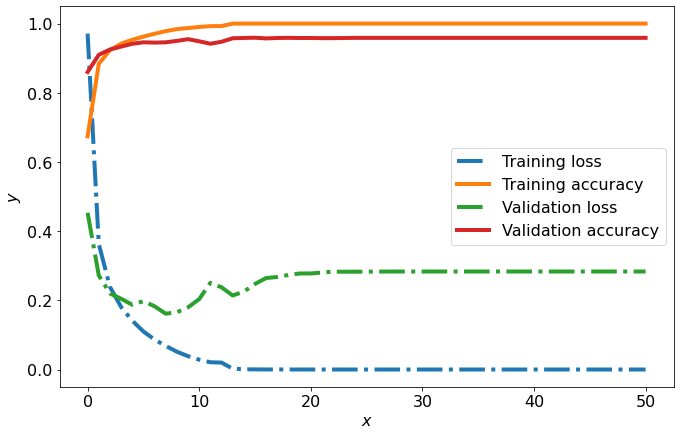

In [24]:
history = pd.DataFrame(history_conv.history)
plot_history(history)

In [25]:
validation_loss__model_conv, validation_acc_model_conv = model_conv.evaluate(validation_images, 
                                                                             validation_labels, 
                                                                             verbose=0)
print('validation_acc with model_dense:', round(validation_acc_model_dense, 3))
print('validation_acc with model_conv:', round(validation_acc_model_conv, 3))

validation_acc with model_dense: 0.801
validation_acc with model_conv: 0.959


***
<font color='blue'><b>Conclusion with Model 2</b> : Using a simple convolution network with a stack of <b>Conv2D</b> and <b>MaxPooling2D</b> layers before the Dense layers has allowed to <b>improve the score from 79 to 96%</b>. In the next model we will try to reduce the overfitting by adding Dropout layers.</font>
***

# MODEL n°3 

## Improving the convolution network in term of `score performance` and `training speed`:  
* Using additional `Convolutional` layers.  
* Adding `Dropout` layers. Dropout is a regularization technique to reduce the network dependency to individual neurons. Some randomly chosen neurons (both hidden and visible) will just be ignored during the training phase.  
* Adding `Batch Normalization` layers. Batch normalization will automatically standardize the inputs to the following layer. It will accelerate the training process and may also improve the performance of the model via a small regularization effect.  
* Using `batch size` in training to have the network train faster. The batch size is the number of samples that are passed to the network at once. The weights will then be updated after each propagation of a batch size.  

In [26]:
model_conv2 = models.Sequential()

model_conv2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model_conv2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv2.add(layers.BatchNormalization())
model_conv2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_conv2.add(layers.Dropout(rate=0.05))

model_conv2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_conv2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_conv2.add(layers.BatchNormalization())
model_conv2.add(layers.MaxPooling2D((2, 2)))
model_conv2.add(layers.Dropout(0.05))

model_conv2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_conv2.add(layers.Flatten())
model_conv2.add(layers.Dropout(0.125))
model_conv2.add(layers.Dense(64, activation='relu'))
model_conv2.add(layers.Dropout(0.25))
model_conv2.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Visualizing model
model_conv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)        

In [27]:
model_conv2.input

<tf.Tensor 'conv2d_3_input:0' shape=(None, 28, 28, 1) dtype=float32>

## COMPILATION and TRAINING of model_conv

In [28]:
# Compilation step
model_conv2.compile(optimizer=optimizers.RMSprop(lr=1e-4, momentum=0.9),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']) 

# Training step
callbacks_list = [callbacks.EarlyStopping(monitor='loss', patience=2,),
    callbacks.ModelCheckpoint(filepath='model_conv2.h5', monitor='val_loss', save_best_only=True,),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)]

history_conv2 = model_conv2.fit(train_images, train_labels, 
                                epochs=100,
                                batch_size=100,
                                callbacks = callbacks_list,
                                validation_data = (validation_images, validation_labels),
                                verbose=0)

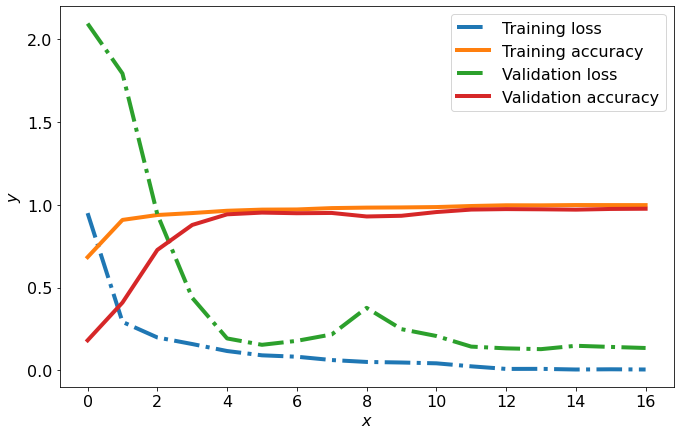

In [29]:
history = pd.DataFrame(history_conv2.history)
plot_history(history)

In [30]:
validation_loss_model_conv2, validation_acc_model_conv2 = model_conv2.evaluate(validation_images,
                                                                               validation_labels,
                                                                               verbose=0)
print('validation_acc with model_dense:', round(validation_acc_model_dense, 3))
print('validation_acc with model_conv:', round(validation_acc_model_conv, 3))
print('validation_acc with model_conv2:', round(validation_acc_model_conv2, 3))

validation_acc with model_dense: 0.801
validation_acc with model_conv: 0.959
validation_acc with model_conv2: 0.976


***
<font color='blue'><b>Conclusion with Model 3</b>: Adding Regularization techniques <b>Dropout</b> and <b>Batch Normalization</b> has clearly reduced the overfitting and also allowed to <b>improve the score from 96 to 97.6%</b>.</font>
***

# MODEL n°4   

## Trying to improve our convolution network using `Data Augmentation` in order to further reduce overfitting:  

Overfitting is caused by having too few samples to learn from. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time the model will not see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In [31]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

# apply some data augmentation on the training set (only, not on the validation set)
train_datagen=ImageDataGenerator(rotation_range=15,
                                   width_shift_range=2,
                                   height_shift_range=2,
                                   # horizontal_flip=True,
                                   fill_mode='nearest')

train_set=train_images_flatten.reshape((train_images_flatten.shape[0], 
                                        train_images_flatten.shape[1], 
                                        train_images_flatten.shape[2], 1))
validation_set=validation_images_flatten.reshape((validation_images_flatten.shape[0], 
                                                  validation_images_flatten.shape[1], 
                                                  validation_images_flatten.shape[2], 1))

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [32]:
train_set.shape

(9600, 28, 28, 1)

In [33]:
train_labels.shape

(9600, 10)

In [34]:
# # Plot digits after data augmentation
# plt.figure(figsize=(9,9))
# example_images = np.array(train_datagen.flow(train_set, train_labels, batch_size=5))[:25]
# plot_digits(example_images, images_per_row=5)
# plt.show()

In [35]:
# Architecture
model_data_aug = models.Sequential()

model_data_aug.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model_data_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_data_aug.add(layers.BatchNormalization())
model_data_aug.add(layers.MaxPooling2D((2, 2)))
model_data_aug.add(layers.Dropout(0.05))

model_data_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_data_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_data_aug.add(layers.BatchNormalization())
model_data_aug.add(layers.MaxPooling2D((2, 2)))
model_data_aug.add(layers.Dropout(0.05))

model_data_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_data_aug.add(layers.Flatten())
model_data_aug.add(layers.Dropout(0.125))
model_data_aug.add(layers.Dense(64, activation='relu'))
model_data_aug.add(layers.Dropout(0.25))
model_data_aug.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# Compilation step
model_data_aug.compile(optimizer=optimizers.RMSprop(lr=1e-4, momentum=0.9),
                       loss='categorical_crossentropy',
                       metrics=['accuracy']) 

# Training step
callbacks_list = [callbacks.EarlyStopping(monitor='loss', patience=2,),
    callbacks.ModelCheckpoint(filepath='model_data_aug.h5', monitor='val_loss', save_best_only=True,),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]

train_batchsize = 100

history_data_aug = model_data_aug.fit(train_datagen.flow(train_set, train_labels, batch_size=train_batchsize),
                                     steps_per_epoch=len(train_set)//train_batchsize,
                                     epochs=100,
                                     batch_size=train_batchsize,
                                     callbacks=callbacks_list,
                                     validation_data=(validation_set, validation_labels),
                                     verbose=0)

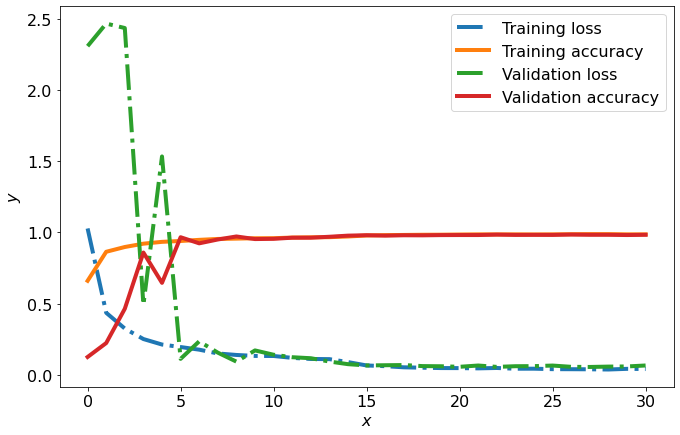

In [36]:
history = pd.DataFrame(history_data_aug.history)
plot_history(history)

In [37]:
validation_loss_data_aug, validation_acc_data_aug = model_data_aug.evaluate(validation_set, 
                                                                            validation_labels, 
                                                                            verbose=0)
print('validation_acc with model_dense:', round(validation_acc_model_dense, 3))
print('validation_acc with model_conv:', round(validation_acc_model_conv, 3))
print('validation_acc with model_conv2:', round(validation_acc_model_conv2, 3))
print('validation_acc with model_data_aug:', round(validation_acc_data_aug, 3))

validation_acc with model_dense: 0.801
validation_acc with model_conv: 0.959
validation_acc with model_conv2: 0.976
validation_acc with model_data_aug: 0.983


***
<font color='blue'><b>Conclusion with Model 4</b>: Thanks to <b>data augmentation</b> and <b>dropout</b>, we are <b>no longer overfitting</b>: the training curves are closed to the validation curves. This has improved the accuracy of our model to a new <b>score of 98.3%</b>.  
As a next step to try to improve the accuracy of our model we will use a pre-trained model.
</font>
***

# MODEL n°5

## Trying to improve our convolution network using `Transfer learning` from VGG16:  

The idea is to replace the convolutional base (part before the Flatten layer) of our network by the one of the VGG16 network trained on ImageNet. This should allow to extract more interesting features from our digit images.

In [38]:
from keras.applications import VGG16
import cv2

model_vgg = VGG16(weights="imagenet",
                  include_top=False, # including or not the densely-connected classifier
                  input_shape=(32,32,3)
                 )

model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

Minimal image size to be used with VGG16 network is 32x32. We will resize the input images from 28x28 to 32x32.

In [39]:
print('train_set: ' + str(train_set.shape))
print('validation_set: ' + str(validation_set.shape))

train_set: (9600, 28, 28, 1)
validation_set: (2400, 28, 28, 1)


In [40]:
# rezize of the images
train_set_resized_list = [cv2.resize(x, (32,32)).reshape((1,32,32,1)) for x in train_set]
validation_set_resized_list = [cv2.resize(x, (32,32)).reshape((1,32,32,1))  for x in validation_set]

train_set_resized = np.concatenate(train_set_resized_list)
validation_set_resized = np.concatenate(validation_set_resized_list)

In [41]:
print('train_set_resized: ' + str(train_set_resized.shape))
print('validation_set_resized: ' + str(validation_set_resized.shape))

train_set_resized: (9600, 32, 32, 1)
validation_set_resized: (2400, 32, 32, 1)


VGG16 expects 3-channel images. We will "fake" the three channel image by duplicating the same data in all 3 layers.

In [42]:
train_set_resized_3=np.concatenate([train_set_resized, 
                                    train_set_resized, 
                                    train_set_resized], axis=3)
validation_set_resized_3=np.concatenate([validation_set_resized, 
                                         validation_set_resized, 
                                         validation_set_resized], axis=3)

Example of obtained image after the resize:

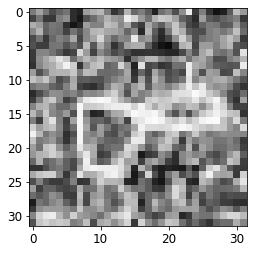

In [43]:
plt.imshow(train_set_resized_3[15])

Original image:

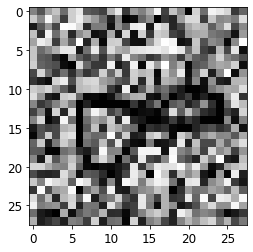

In [44]:
plt.imshow(train_images_flatten[15], cmap=plt.cm.binary)
plt.show()

Let's build the top of the network.

In [45]:
model_transfer = models.Sequential()
model_transfer.add(model_vgg)
model_transfer.add(layers.Flatten())
model_transfer.add(layers.Dropout(0.125))
model_transfer.add(layers.Dense(64, activation='relu'))
model_transfer.add(layers.Dropout(0.25))
model_transfer.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model_transfer.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 14,748,170
Non-trainable params: 0
__________________________________________

We freeze the convolutional base in order to prevent its weights from getting updated during training (for faster training).

In [46]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model_transfer.trainable_weights))

model_vgg.trainable = False # False if we want to freeze the layers 
                            # from the pre-trained part of the network

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model_transfer.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


We then compile and train our model:

In [47]:
# Compilation step
model_transfer.compile(optimizer=optimizers.RMSprop(lr=1e-4, momentum=0.9),
                       loss='categorical_crossentropy',
                       metrics=['accuracy']) 

# Training step
callbacks_list = [callbacks.EarlyStopping(monitor='loss', patience=5,),
    callbacks.ModelCheckpoint(filepath='model_transfer.h5', monitor='val_loss', save_best_only=True,),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]

train_batchsize = 100

history_transfer = model_transfer.fit(
    train_datagen.flow(train_set_resized_3, train_labels, batch_size=train_batchsize),
    steps_per_epoch=len(train_set_resized_3)//train_batchsize,
    epochs=100,
    batch_size=train_batchsize,
    callbacks=callbacks_list,
    validation_data=(validation_set_resized_3, validation_labels),
    verbose=0)

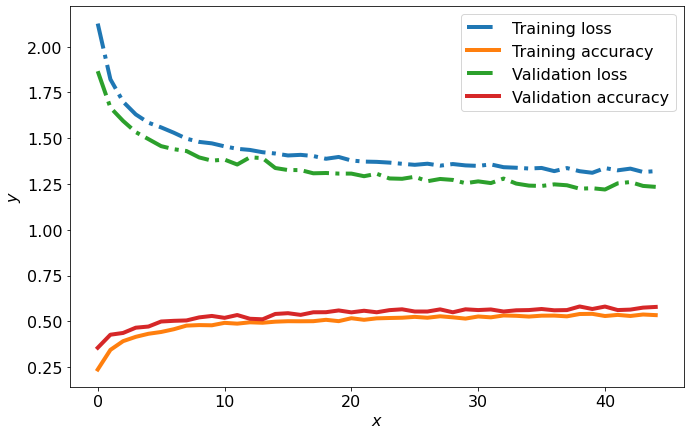

In [48]:
history = pd.DataFrame(history_transfer.history)
plot_history(history)

In [49]:
validation_loss_model_transfer, validation_acc_model_transfer = model_transfer.evaluate(validation_set_resized_3, 
                                                                                        validation_labels, 
                                                                                        verbose=0)
print('validation_acc with model_dense:', round(validation_acc_model_dense, 3))
print('validation_acc with model_conv:', round(validation_acc_model_conv, 3))
print('validation_acc with model_conv2:', round(validation_acc_model_conv2, 3))
print('validation_acc with model_data_aug:', round(validation_acc_data_aug, 3))
print('validation_acc with model_transfer:', round(validation_acc_model_transfer, 3))

validation_acc with model_dense: 0.801
validation_acc with model_conv: 0.959
validation_acc with model_conv2: 0.976
validation_acc with model_data_aug: 0.983
validation_acc with model_transfer: 0.578


***
<font color='blue'><b>Conclusion with Model 5</b>: Using <b>transfer learning form VGG16 model has not helped to get a better model</b>. The loss gets stuck at a quite high level. The VGG16 might not be adapted or we should may be try using only the first layers of the VGG16 model. It might also requires more optimisations on hyperparameters such as learning rate.  
As a next step we will try to perform hyperparameters optimisation based on model_conv2 .
</font>
***

# MODEL n°6   

## Trying to improve our convolution network using `hyperparameters tuning` with Keras Tuner:  

To perform hyperparameter tuning we need to define which hyperparameters need to be optimized and in what range (= search space). For example for our conv2 model the below hyperparameters can be tuned:  
* The number of filters of the convolutional layers.  
* The dropout rate of dropout layers.  
* The number of neurons and the dense layers.  
* The activation function for the last dense layer.  
* The learning rate in the compilation step.  

## Keras Tuner Hypermodels

In [52]:
"""
- We define a `HyperModel` class based on our model
- It returns a compiled model
- It uses hyperparameters defined on the fly
"""

from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

class HyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
                                input_shape=self.input_shape))
        model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')) 
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(rate=0.05))
       
        model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
        model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(rate=0.05))
        
        model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dropout(rate=0.25))
        model.add(layers.Dense(units=hp.Int('units', min_value=64, max_value=512,
                                            default=64, step=32), 
                               activation=hp.Choice('dense_activation', 
                                                    values=['relu', 'sigmoid'],
                                                    default='relu')))
        model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, 
                                               default=0.3, step=0.1)))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=optimizers.RMSprop(hp.Choice('learning_rate',[1e-1, 1e-2, 1e-3, 1e-4]), 
                                                   momentum=0.9),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

hypermodel = HyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

## Hyperband Tuner

In [53]:
EXECUTION_PER_TRIAL=2
HYPERBAND_MAX_EPOCHS=30

# from kerastuner.tuners import RandomSearch

# tuner = RandomSearch(hypermodel,
#                     objective='val_accuracy',
#                     max_trials=MAX_TRIALS,
#                     executions_per_trial=EXECUTION_PER_TRIAL,
#                     directory='random_search')


from kerastuner.tuners import Hyperband

tuner=Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='MNIST')

# Show a summary of the search
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project hyperband\MNIST\oracle.json
INFO:tensorflow:Reloading Tuner from hyperband\MNIST\tuner0.json


## Tuning step

In [101]:
import IPython

# Callback to clear the training outputs at the end of every training step
class ClearTrainingOutput(callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

# Run of the hyperparameter search
tuner.search(train_images, train_labels, #train_datagen.flow(train_set, train_labels, batch_size=train_batchsize),
    epochs=HYPERBAND_MAX_EPOCHS,
    validation_data=(validation_set, validation_labels),
    callbacks = [ClearTrainingOutput()])

tuner.results_summary()

INFO:tensorflow:Oracle triggered exit


## Score evaluation

In [54]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
validation_loss_hyperparam_optim, validation_acc_hyperparam_optim = best_model.evaluate(validation_set, 
                                                                                        validation_labels, 
                                                                                        verbose=0)

In [55]:
print('validation_acc with model_dense:', round(validation_acc_model_dense, 3))
print('validation_acc with model_conv:', round(validation_acc_model_conv, 3))
print('validation_acc with model_conv2:', round(validation_acc_model_conv2, 3))
print('validation_acc with model_data_aug:', round(validation_acc_data_aug, 3))
print('validation_acc with model_transfer:', round(validation_acc_model_transfer, 3))
print('validation_acc with model_hyperparam_optim:', round(validation_acc_hyperparam_optim, 3))

validation_acc with model_dense: 0.801
validation_acc with model_conv: 0.959
validation_acc with model_conv2: 0.976
validation_acc with model_data_aug: 0.983
validation_acc with model_transfer: 0.578
validation_acc with model_hyperparam_optim: 0.976


***
<font color='blue'><b>Conclusion with Model 6</b>: Here we wanted to give a try to <b>hyperparameters optimization with Keras Tuner</b> applied on our full convolutional network. We have tuned the learning rate as well as the number of units, the activation function, the dropout rate on some of the layers. It took few hours to run.  
At the end the <b>validation accuracy has not improved and remained at 97.6%</b>. The obtained score is below our best model using data augmentation. But this score could probably get improved by using the Keras Tuner on our model using data augmentation or by applying the tuning on the layers that are closer to the base of the network.
</font>
***

# Generationg predictions on the test dataset using our best model

In [57]:
# Function to generate classes predictions for the test data
def predict(model, test_data):
    
    test_images_flatten=np.array(test_data).reshape(len(test_data), 28, 28)
    test_set=test_images_flatten.reshape((test_images_flatten.shape[0], test_images_flatten.shape[1], test_images_flatten.shape[2], 1))
    test_set=test_set.astype('float32')
    predicted_classes=model.predict_classes(test_set)
    
    # Create file for submission in Kaggle
    df = pd.DataFrame(predicted_classes)
    df['Id'] = df.index
    df[[df.columns[0], df.columns[1]]] = df[[df.columns[1], df.columns[0]]]
    df.columns = ['Id', 'Category']
    df.to_csv('Submission.csv', index=False, header=True)
    
    return(predicted_classes)

predict(model_data_aug, test_data)

array([6, 6, 8, ..., 6, 0, 3], dtype=int64)